# NNDL [21/22] - Assignment 2

### Dr. Alberto Testolin, Dr. Umberto Michieli


Faorlin Tommaso, student ID 2021857 (Physics of Data)

In [1]:
#BASIC TOOLS
import pandas as pd                 #pandas library
import numpy as np                  #numpy library
import matplotlib.pyplot as plt     #plotting library
import random
import seaborn as sns
import os
from tqdm import tqdm
import plotly.express as px

#SKLEARN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.stats import loguniform 
from sklearn.metrics import confusion_matrix

#CUSTOM LIBRARIES
import models

#PYTORCH
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torchvision

#LIGHTNING
import pytorch_lightning as pl
from pytorch_lightning import Callback
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.progress import TQDMProgressBar

#OPTUNA
import optuna 
from optuna.integration import PyTorchLightningPruningCallback

#fixing a seed for reproducibility
np.random.seed(1)
torch.manual_seed(0)

#setting the verbosity
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [2]:
data_dir = 'dataset'

vanilla_transform = transforms.Compose( [transforms.ToTensor()] )

total_train_dataset = datasets.FashionMNIST(data_dir, train=True, download=True, transform=vanilla_transform)
test_dataset        = datasets.FashionMNIST(data_dir, train=False,download=True, transform=vanilla_transform)
#<class 'torchvision.datasets.mnist.FashionMNIST'>

train_size = len(total_train_dataset)
train_split = 0.8

train_dataset, valid_dataset = torch.utils.data.random_split(total_train_dataset, [int(train_split*train_size),int(train_size-train_split*train_size)])
#<class 'torch.utils.data.dataset.Subset'>

train_dataloader = DataLoader(train_dataset, batch_size = 256, shuffle=True,  num_workers=4)
valid_dataloader = DataLoader(valid_dataset, batch_size = 256, shuffle=False, num_workers=4)
test_dataloader  = DataLoader(test_dataset,  batch_size = 256, shuffle=False)
#<class 'torch.utils.data.dataloader.DataLoader'>


# Quick data visualization

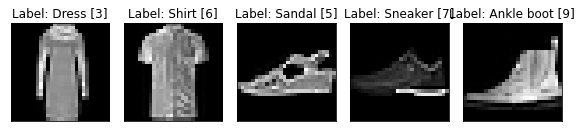

In [3]:
train_dataset_plot = datasets.FashionMNIST('classifier_data', train=True,  download=True)

label_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

fig, axs = plt.subplots(1, 5, figsize=(8,8))
for ax in axs.flatten():
    img, label = random.choice(train_dataset_plot)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title(f'Label: {label_names[label]} [{label}]')
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()
plt.savefig('graphs/FashionMNIST_samples.pdf')

# Convolutional Autoencoder (CAE)

[2 pt]: Implement and test (convolutional) autoencoder, reporting the trend of reconstruction loss and some examples of image reconstruction; explore advanced optimizers and regularization methods. To accomplish this first task we exploit the code written during the lab activities and Pytorch Lightning.

In [57]:
hyper_parameters = {
        'encoded_space_dim' : 2,
        'opt'               : 'Adam',
        'lr'                : 5e-4,
        'reg'               : 1e-5,
        }
CAE = models.LightningAutoEncoder(hyper=hyper_parameters)
CAE.configure_loss(nn.MSELoss())

In [58]:
img, _ = test_dataset[0]
img = img.unsqueeze(0)
print('- original image shape:', img.shape)
img_enc = CAE.encoder(img)
print('- encoded image shape:', img_enc.shape)
dec_img = CAE.decoder(img_enc)
print('- decoded image shape:', dec_img.shape)

if (img.shape == dec_img.shape):
    print('[OK] input and output dimension match')
else:
    print('[ERROR] input and output dimension mismatch')

- original image shape: torch.Size([1, 1, 28, 28])
- encoded image shape: torch.Size([1, 2])
- decoded image shape: torch.Size([1, 1, 28, 28])
[OK] input and output dimension match


In [59]:
class MetricsCallback(Callback):
    def __init__(self):
        super().__init__()
        self.metrics = []
    def on_validation_end(self, trainer, pl_module):
        self.metrics.append({key: val.item() for (key, val) in trainer.callback_metrics.items()})

In [60]:
metrics_callback = MetricsCallback()

#we define a custom logger not to mess up with other future logs
vanilla_logger = pl_loggers.TensorBoardLogger('vanilla_model_logs/')

trainer = pl.Trainer(
    logger               = vanilla_logger,
    enable_checkpointing = False,
    max_epochs           = 20,
    gpus                 = 0,
    callbacks            = [metrics_callback, EarlyStopping(monitor='val_loss')]
    )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [61]:
trainer.fit(CAE, train_dataloader, valid_dataloader)

Missing logger folder: vanilla_model_logs/default

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 24.5 K
1 | decoder   | Sequential | 24.8 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
49.3 K    Trainable params
0         Non-trainable params
49.3 K    Total params
0.197     Total estimated model params size (MB)


Epoch 19: 100%|██████████| 235/235 [00:53<00:00,  4.43it/s, loss=0.0326, v_num=0, val_loss=0.0328]


In [62]:
#uncomment to re-test the best model
trainer.save_checkpoint('vanilla_cae.ckpt')

In [63]:
checkpoint_cae_vanilla = torch.load('vanilla_cae.ckpt')
best_model = models.LightningAutoEncoder(hyper=hyper_parameters)
best_model.load_state_dict(checkpoint_cae_vanilla['state_dict'])

<All keys matched successfully>

In [64]:
trainer.callbacks[0].metrics.pop(0)

history = trainer.callbacks[0].metrics

train_loss_hist = [history[i].get('train_loss') for i in range(len(history))]
val_loss_hist = [history[i].get('val_loss') for i in range(len(history))]

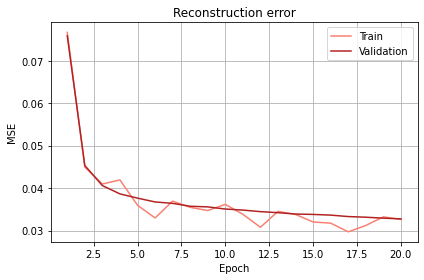

In [70]:
x = np.arange(1,len(train_loss_hist)+1)

plt.plot(x,train_loss_hist, label = 'Train', color = 'salmon')

plt.plot(x, val_loss_hist, label = 'Validation', color='firebrick')

plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid()
plt.title('Reconstruction error')
plt.tight_layout()
plt.savefig('graphs/losses.pdf')

## Optuna optimization
[1 pt]: optimize hyperparameters using grid/random search or automatic tuning tools (e.g., Optuna). To accomplish this task we embed our CAE in a PytorchLightning module and optimize the hyperparameters with Optuna. Here we also try different optimizers, learning rates and regularizations.

In [74]:
def objective(trial):
    #objective function which returns thd numerical value to be optimized (validation loss)

    #OPTUNA
    encoded_space_dim = trial.suggest_int('encoded_space_dim', 2, 50)
    opt               = trial.suggest_categorical('opt', ['SGD', 'Adam', 'Adadelta', 'Adagrad'])
    lr                = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    reg               = trial.suggest_loguniform('reg', 1e-5, 1e-4)

    hyper_parameters = {
        'encoded_space_dim' : encoded_space_dim,
        'opt'               : opt,
        'lr'                : lr,
        'reg'               : reg,
        }

    model = models.LightningAutoEncoder(hyper_parameters)
    model.configure_loss(nn.MSELoss())
    
    trainer = pl.Trainer(
        logger               = True,
        limit_val_batches    = 1., 
        enable_checkpointing = False,
        max_epochs           = 15,
        gpus                 = 0,
        callbacks            = [PyTorchLightningPruningCallback(trial, monitor="val_loss")],
        )
        
    trainer.logger.log_hyperparams(hyper_parameters)

    trainer.fit(model, train_dataloader, valid_dataloader)

    return trainer.callback_metrics["val_loss"].item()

In [75]:
pruner = optuna.pruners.MedianPruner()

study  = optuna.create_study(study_name     = "AutoEncoder", 
                             storage        = 'sqlite:///AutoEncoder.db', 
                             direction      = "minimize", 
                             pruner         = pruner, 
                             load_if_exists = True)
                             
#study.optimize(objective, n_trials = 150, timeout = None)

In [76]:
fig = optuna.visualization.plot_intermediate_values(study)
#fig.write_image("graphs/fig1.pdf")

In [77]:
fig  =optuna.visualization.plot_optimization_history(study, target_name='Validation loss')
#fig.write_image("graphs/fig2.pdf")

In [78]:
fig= optuna.visualization.plot_parallel_coordinate(study, target_name='Validation loss')
#fig.write_image("graphs/fig3.pdf")

Training of the best model

In [70]:
#we load the study stored in 'storage'
study  = optuna.create_study(study_name     = "AutoEncoder", 
                             storage        = 'sqlite:///AutoEncoder.db', 
                             direction      = "minimize", 
                             load_if_exists = True)

print('RESULTS FOR THE BEST TRIAL:')

best_trial = study.best_trial

print("\n- Validation loss: {}".format(best_trial.value))
for key, value in best_trial.params.items():
    print("- {}: {}".format(key, value))

RESULTS FOR THE BEST TRIAL:

- Validation loss: 0.01497035101056099
- encoded_space_dim: 10
- lr: 0.006720717597696386
- opt: Adam
- reg: 1.759802608188357e-05


In [71]:
best_model = models.LightningAutoEncoder(best_trial.params)
best_model.configure_loss(nn.MSELoss())

In [81]:
trainer = pl.Trainer(
    logger               = True,
    limit_val_batches    = 1., 
    enable_checkpointing = False,
    max_epochs           = 100,
    gpus                 = 0,
    callbacks            = [EarlyStopping(monitor='val_loss'), TQDMProgressBar(refresh_rate = 20)])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [16]:
#uncomment to re-train the best model
#trainer.fit(best_model, train_dataloader, valid_dataloader)


  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 25.0 K
1 | decoder   | Sequential | 25.3 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Epoch 34: 100%|██████████| 235/235 [00:23<00:00, 10.00it/s, loss=0.0142, v_num=150, val_loss=0.0141]


In [20]:
#uncomment to re-test the best model
#trainer.test(best_model, test_dataloader)

Testing: 100%|██████████| 40/40 [00:02<00:00, 17.08it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.0141181331127882}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 40/40 [00:02<00:00, 16.54it/s]


[{'test_loss': 0.0141181331127882}]

In [21]:
#uncomment to save a new best model
#trainer.save_checkpoint("best_cae.ckpt")

In [72]:
checkpoint_cae = torch.load('best_cae.ckpt')
best_model.load_state_dict(checkpoint_cae['state_dict'])

<All keys matched successfully>

Let's plot some reconstructed images

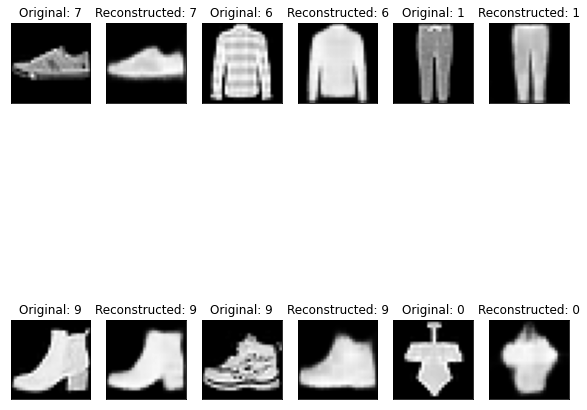

In [84]:
fig, ax = plt.subplots(2,6, figsize=(10,10))
for i in range(2):
    for j in range(3):
        a=random.randint(1,10001)
        img, label = test_dataset[a]
        encoded_img  = best_model.encoder(img.unsqueeze(0))
        decoded_img  = best_model.decoder(encoded_img)
        ax[i][j*2].imshow(np.array(img[0]), cmap='gist_gray')
        ax[i][j*2].set_title('Original: %d' % label)
        ax[i][j*2].set_xticks([])
        ax[i][j*2].set_yticks([])
        ax[i][j*2+1].imshow(decoded_img.squeeze().cpu().detach().numpy(), cmap='gist_gray')
        ax[i][j*2+1].set_title('Reconstructed: %d' % label)
        ax[i][j*2+1].set_xticks([])
        ax[i][j*2+1].set_yticks([])
plt.savefig('graphs/Reconstruced_CAE.pdf')

# Fine tuning
[1 pt]: fine-tune the (convolutional) autoencoder using a supervised classification task, and compare classification accuracy and learning speed with results achieved in Homework 1


In [5]:
#we load the study stored in 'storage'
study  = optuna.create_study(study_name     = "AutoEncoder", 
                             storage        = 'sqlite:///AutoEncoder.db', 
                             direction      = "minimize", 
                             load_if_exists = True)
best_trial = study.best_trial

In [6]:
#load the pretrained model
checkpoint_cae = torch.load('best_cae.ckpt')
pretrained = models.LightningAutoEncoder(hyper=best_trial.params)
pretrained.load_state_dict(checkpoint_cae['state_dict'])

#build the supervised convolutional autoencoder
supervisedCAE = models.SupervisedCAE(best_trial.params, pretrained)
supervisedCAE.configure_loss(torch.nn.NLLLoss())

#'freeze' the parameters of the encoder so to train the FCN layer only
for par in supervisedCAE.encoder.parameters():
    par.requires_grad = False

In [7]:
trainer = pl.Trainer(gpus= 0, 
                     max_epochs = 50, 
                     callbacks  = [EarlyStopping(monitor='val_loss')])
                     
trainer.fit(supervisedCAE, train_dataloader, valid_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | Sequential | 25.0 K
1 | fine_tuner | Sequential | 1.4 K 
2 | accuracy   | Accuracy   | 0     
3 | loss_func  | NLLLoss    | 0     
------------------------------------------
1.4 K     Trainable params
25.0 K    Non-trainable params
26.4 K    Total params
0.106     Total estimated model params size (MB)


/Users/tommasofaorlin/opt/anaconda3/envs/torch/lib/python3.8/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch 8: 100%|██████████| 235/235 [00:16<00:00, 14.39it/s, loss=0.432, v_num=153, val_loss=0.444]


In [8]:
trainer.test(supervisedCAE, test_dataloader)

/Users/tommasofaorlin/opt/anaconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing:  98%|█████████▊| 39/40 [00:03<00:00, 21.97it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.8334000110626221}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 40/40 [00:03<00:00, 12.93it/s]


[{'accuracy': 0.8334000110626221}]

In [9]:
y_pred = []
y_true = []

for inputs, labels in test_dataloader:
        output = supervisedCAE(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

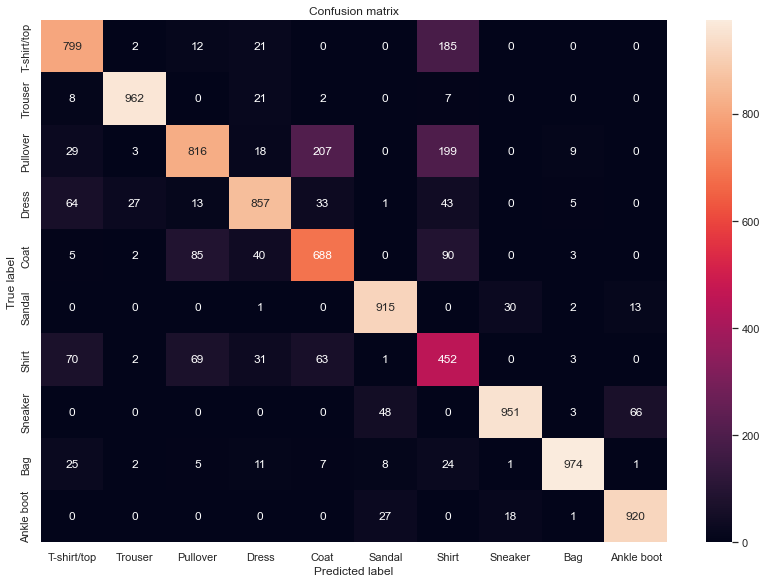

In [28]:
#print('The final accuracy on the test set is: ', accuracy_score(test_set_label, label_pred))
label_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(confusion_matrix(y_pred, y_true), annot = True, xticklabels = label_names, yticklabels = label_names, fmt = 'g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.tight_layout()
plt.savefig('graphs/confusion_matrix.pdf')

## CAE Latent space exploration

[2 pt]: explore the latent space structure (e.g., PCA, t-SNE) and generate new samples from latent codes

In [56]:
#we load the study stored in 'storage'
study  = optuna.create_study(study_name     = "AutoEncoder", 
                             storage        = 'sqlite:///AutoEncoder.db', 
                             direction      = "minimize", 
                             load_if_exists = True)

best_trial = study.best_trial

In [57]:
checkpoint_cae = torch.load('best_cae.ckpt')
best_model = models.LightningAutoEncoder(hyper=best_trial.params)
best_model.load_state_dict(checkpoint_cae['state_dict'])

<All keys matched successfully>

We map each sample to its latent representation

In [49]:
best_model.eval()
#encode the test samples
encoded_samples = []
enc_aut = np.zeros(10+1) #latent space + label
for sample in tqdm(test_dataset):
    label = sample[1]
    with torch.no_grad():
        encoded_img  = best_model.forward(sample[0].unsqueeze(0))[0].flatten().cpu().numpy()
    encoded_sample = {f"comp-{i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label_names[label]
    encoded_samples.append(encoded_sample)
    enc_aut = np.vstack((enc_aut, np.hstack((encoded_img, label))))

100%|██████████| 10000/10000 [00:05<00:00, 1991.01it/s]


### PCA

In [89]:
encoded_samples = pd.DataFrame(encoded_samples)
encoded_space_dim = hyper_parameters['encoded_space_dim']
#PCA
pca = PCA(n_components=2).fit(encoded_samples.iloc[:,0:encoded_space_dim])
columns = [ f'comp-{i}' for i in range(n_components)]
compressed_samples = pd.DataFrame(pca.transform(encoded_samples.iloc[:,0:encoded_space_dim]), columns =columns)

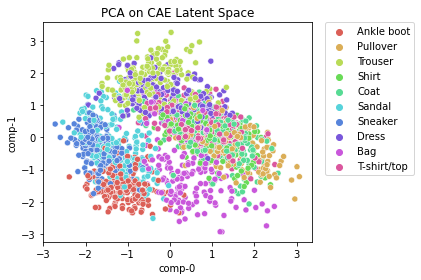

In [90]:
sns.scatterplot(x="comp-0", 
                y="comp-1", 
                hue=encoded_samples.label.tolist()[:2000],
                palette=sns.color_palette("hls", 10),
                data=compressed_samples.iloc[:2000]).set(title="PCA on CAE Latent Space")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout()
plt.savefig('graphs/PCA_CAE.pdf')

### TSNE

In [73]:
encoded_samples = pd.DataFrame(encoded_samples)
encoded_space_dim = hyper_parameters['encoded_space_dim']
#TSNE
tsne = TSNE(n_components = 2).fit(encoded_samples.iloc[:, 0:encoded_space_dim])
columns = [ f'comp-{i}' for i in range(n_components)]
compressed_samples = pd.DataFrame(tsne.fit_transform(encoded_samples.iloc[:,0:encoded_space_dim]), columns=columns)

/Users/tommasofaorlin/opt/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/tommasofaorlin/opt/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/Users/tommasofaorlin/opt/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/tommasofaorlin/opt/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



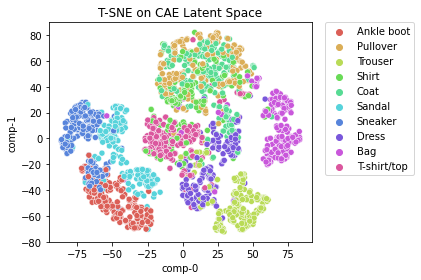

In [81]:
sns.scatterplot(x="comp-0", 
                y="comp-1", 
                hue=encoded_samples.label.tolist()[:2000],
                palette=sns.color_palette("hls", 10),
                data=compressed_samples.iloc[:2000]).set(title="T-SNE on CAE Latent Space")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout()
plt.savefig('graphs/TSNE_CAE.pdf')

# Variational Autoencoder (VAE)
[2 pt]: implement and test variational (convolutional) autoencoder or GAN or SimCLR

In [4]:
hyper_parameters = {
    'encoded_space_dim' : 10,
    'opt'               : 'Adam',
    'lr'                : 1e-3,
    'reg'               : 0,
    }

vae = models.VariationalAutoEncoder(hyper_parameters)

In [62]:
#training
trainer = pl.Trainer(gpus = 0, 
                     max_epochs=100, 
                     callbacks=[EarlyStopping(monitor='val_loss')])
                     
#trainer.fit(vae, train_dataloader, valid_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [7]:
#trainer.test(vae, test_dataloader)

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 6327.28466796875}
--------------------------------------------------------------------------------


[{'test_loss': 6327.28466796875}]

In [8]:
#trainer.save_checkpoint("best_vae.ckpt")

## VAE Latent space exploration
[2 pt]: explore the latent space structure (e.g., PCA, t-SNE) and generate new samples from latent codes

In [5]:
checkpoint_vae = torch.load('best_vae.ckpt')
vae_2 = models.VariationalAutoEncoder(hyper_parameters)
vae_2.load_state_dict(checkpoint_vae['state_dict'])

<All keys matched successfully>

As above, we map each sample to its latent representation

In [ ]:
vae_2.eval()
#encode the test samples
encoded_samples = []
enc_aut = np.zeros(10+1) #latent space + label
for sample in tqdm(test_dataset):
    label = sample[1]
    with torch.no_grad():
        encoded_img  = vae_2.forward(sample[0].unsqueeze(0))[0].flatten().cpu().numpy()
    encoded_sample = {f"comp-{i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label_names[label]
    encoded_samples.append(encoded_sample)
    enc_aut = np.vstack((enc_aut, np.hstack((encoded_img, label))))

### PCA

In [14]:
encoded_samples = pd.DataFrame(encoded_samples)
encoded_space_dim = hyper_parameters['encoded_space_dim']
red_dim = 2
#PCA
pca = PCA(n_components=red_dim).fit(encoded_samples.iloc[:,0:encoded_space_dim])
columns = [ f'comp-{i}' for i in range(red_dim)]
compressed_samples = pd.DataFrame(pca.transform(encoded_samples.iloc[:,0:encoded_space_dim]), columns =columns)

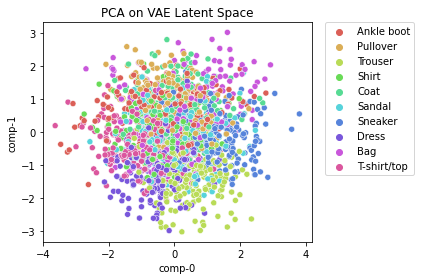

In [15]:
sns.scatterplot(x="comp-0", 
                y="comp-1", 
                hue=encoded_samples.label.tolist()[:2000],
                palette=sns.color_palette("hls", 10),
                data=compressed_samples.iloc[:2000]).set(title="PCA on VAE Latent Space")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout()
plt.savefig('graphs/PCA_VAE.pdf')

### TSNE

In [16]:
encoded_samples = pd.DataFrame(encoded_samples)
encoded_space_dim = hyper_parameters['encoded_space_dim']
#TSNE
tsne = TSNE(n_components = 2).fit(encoded_samples.iloc[:, 0:encoded_space_dim])
columns = [ f'comp-{i}' for i in range(red_dim)]
compressed_samples = pd.DataFrame(tsne.fit_transform(encoded_samples.iloc[:,0:encoded_space_dim]), columns=columns)

/Users/tommasofaorlin/opt/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/tommasofaorlin/opt/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/tommasofaorlin/opt/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/tommasofaorlin/opt/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


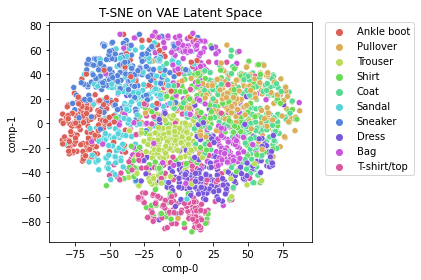

In [68]:
sns.scatterplot(x="comp-0", 
                y="comp-1", 
                hue=encoded_samples.label.tolist()[:2000],
                palette=sns.color_palette("hls", 10),
                data=compressed_samples.iloc[:2000]).set(title="T-SNE on VAE Latent Space")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout()
plt.savefig('graphs/TSNE_VAE.pdf')

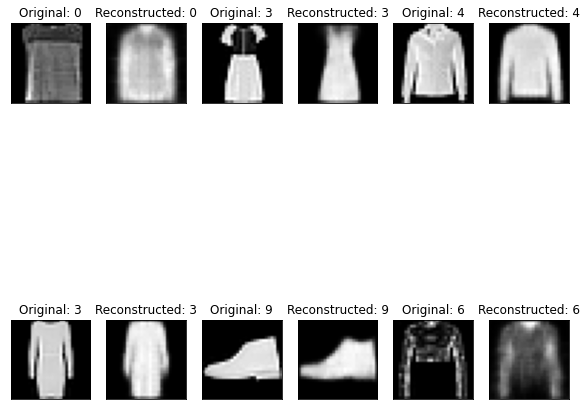

In [18]:
fig, ax = plt.subplots(2,6, figsize=(10,10))
for i in range(2):
    for j in range(3):
        a=random.randint(1,10001)
        img, label = test_dataset[a]
        encoded_img  = vae_2.FCmu(vae_2.encoder(img.unsqueeze(0)))
        decoded_img  = vae_2.decoder(encoded_img)
        ax[i][j*2].imshow(np.array(img[0]), cmap='gist_gray')
        ax[i][j*2].set_title('Original: %d' % label)
        ax[i][j*2].set_xticks([])
        ax[i][j*2].set_yticks([])
        ax[i][j*2+1].imshow(decoded_img.squeeze().cpu().detach().numpy(), cmap='gist_gray')
        ax[i][j*2+1].set_title('Reconstructed: %d' % label)
        ax[i][j*2+1].set_xticks([])
        ax[i][j*2+1].set_yticks([])
plt.savefig('graphs/Reconsrtucted_VAE.pdf')

### Samples generation

We see how new samples (the one in the intermediate steps) can be generated sweeping smoothly between two samples in the test dataset.

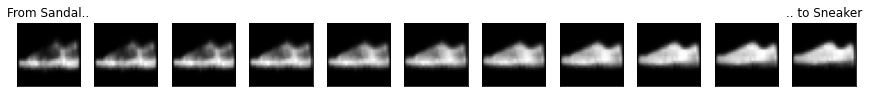

In [80]:
vae_2.eval() #put VAE in evaluation mode

intermediate_steps = 9
total_steps = 2 + intermediate_steps
line = np.linspace(0, 1, total_steps)

fig, axs = plt.subplots(1, total_steps,figsize=(12,6))

start_img, y1 = test_dataset[90]
end_img, y2 = test_dataset[9]

with torch.no_grad():
    start_pos = vae_2.forward(start_img.unsqueeze(0))[0].data.numpy().flatten()
    end_pos = vae_2.forward(end_img.unsqueeze(0))[0].data.numpy().flatten()
    
#create new points in the latent space
points = [start_pos + val * (end_pos - start_pos) for val in line]

for step, (ax, point) in enumerate(zip(axs.ravel(), points)):
    with torch.no_grad():
        img = vae_2.decoder(torch.tensor(point).unsqueeze(0))

    if step == 0:
        ax.set_title("From {}..".format(label_names[y1]))
    if step == total_steps-1:
        ax.set_title(".. to {}".format(label_names[y2]))

    ax.imshow(img.squeeze().numpy(), cmap='gist_gray')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
fig.savefig("graphs/transition_5.pdf")

We also perform a random sampling.

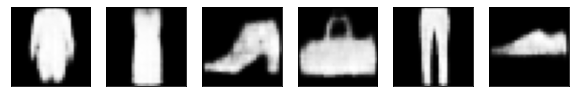

In [73]:
fig, ax = plt.subplots(1,6, figsize=(10,10))

for j in range(6):
    sample = np.float32(6. * np.random.random_sample((10,)) - 3.)
    VAE_img =      vae_2.decoder(torch.tensor(sample).unsqueeze(0))
    ax[j].imshow(VAE_img.squeeze().detach().numpy(), cmap='gist_gray')
    ax[j].set_xticks([])
    ax[j].set_yticks([])
    
plt.savefig('graphs/random_samples.pdf')